# **Import Libraries**

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from datetime import datetime
import os


# **Mount Google Drive**

In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load and Preprocess Data**

In [19]:
# Load the dataset
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')

# Drop the 'Time' column
df = df.drop(columns=['Time'])

# Normalize all features using MinMaxScaler
scaler = MinMaxScaler()
X = df.drop(columns=['Class'])
X_scaled = scaler.fit_transform(X)

# Separate the target
y = df['Class']

# Separate normal transactions and fraudulent transactions
X_normal = X_scaled[y == 0]
X_fraud = X_scaled[y == 1]

# Split normal transactions into training and validation sets
X_train, X_validate = train_test_split(X_normal, test_size=0.2, random_state=42)

# Combine the validation set (normal) and fraud data for validation/testing
X_test = np.concatenate([X_validate, X_fraud])
y_test = np.concatenate([np.zeros(X_validate.shape[0]), np.ones(X_fraud.shape[0])])


# **Define Custom Accuracy Metric**

In [20]:
# Define a custom accuracy metric based on reconstruction error
def custom_accuracy(y_true, y_pred):
    error = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    threshold = 0.02
    return tf.reduce_mean(tf.cast(error < threshold, tf.float32))


# **Build the Autoencoder Model**

In [21]:
# Define the autoencoder model with BatchNormalization, L2 regularization, and Dropout
input_dim = X_train.shape[1]
encoding_dim = 14  # Compression factor

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu", kernel_regularizer=l2(0.001))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(7, activation="relu", kernel_regularizer=l2(0.002))(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
decoder = Dense(encoding_dim, activation="relu", kernel_regularizer=l2(0.002))(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


# **Compile the Model**

In [22]:
# Compile the model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mean_squared_error", metrics=[custom_accuracy])


# **Set Up Callbacks**

In [23]:
# Callbacks
BATCH_SIZE = 256  # Increased batch size
EPOCHS = 100

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath=f'./models/chat.keras', verbose=1, save_best_only=True)
log_dir = f'logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# **Train the Model**

In [24]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_validate, X_validate),
    callbacks=[early_stop, checkpointer, tensorboard_callback]
)


Epoch 1/100
879/889 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy: 0.2756 - loss: 0.0787
Epoch 1: val_loss improved from inf to 0.00886, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - custom_accuracy: 0.2800 - loss: 0.0783 - val_custom_accuracy: 0.9995 - val_loss: 0.0089
Epoch 2/100
879/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_accuracy: 0.9994 - loss: 0.0071
Epoch 2: val_loss improved from 0.00886 to 0.00369, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - custom_accuracy: 0.9994 - loss: 0.0071 - val_custom_accuracy: 0.9997 - val_loss: 0.0037
Epoch 3/100
882/889 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy: 0.9996 - loss: 0.0037
Epoch 3: val_loss improved from 0.00369 to 0.00258, saving model to ./models/chat.keras
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - custom_accuracy: 0.9996 - loss: 0.0037 - val_custom_accuracy: 0.9997 - val_loss: 0.0026
Epoch 4/100
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_acc

# **Evaluate the Model**

In [25]:
# Evaluate the model on the combined test set
predictions = autoencoder.predict(X_test)

# Calculate the reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

# Dynamically determine the threshold based on the Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y_test, mse)
pr_auc = auc(recall, precision)
optimal_idx = np.argmax(precision * recall)  # You can optimize this criterion
threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on PR AUC: {threshold}")

error_df['Predicted_class'] = (error_df['Reconstruction_error'] > threshold).astype(int)


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Optimal threshold based on PR AUC: 0.009975627158738743


# **Generate Reports and Plots**

Confusion Matrix:
 [[56778    85]
 [  214   278]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.77      0.57      0.65       492

    accuracy                           0.99     57355
   macro avg       0.88      0.78      0.82     57355
weighted avg       0.99      0.99      0.99     57355

F1-score (micro): 0.994786853805248
Precision: 0.8810426537077167
Recall: 0.7817729147606092
Accuracy Score: 0.994786853805248
AUC-ROC Score: 0.9518516477129669


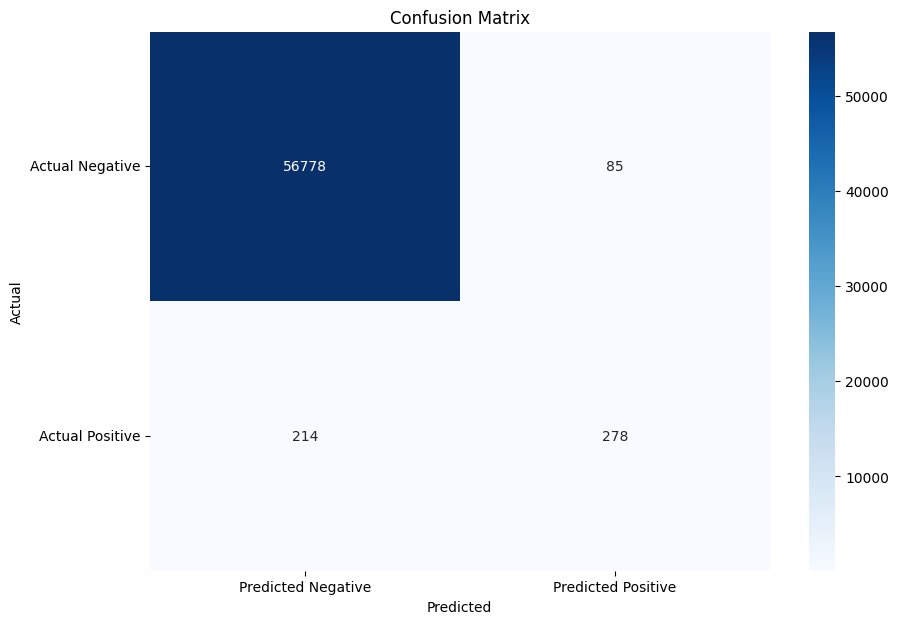

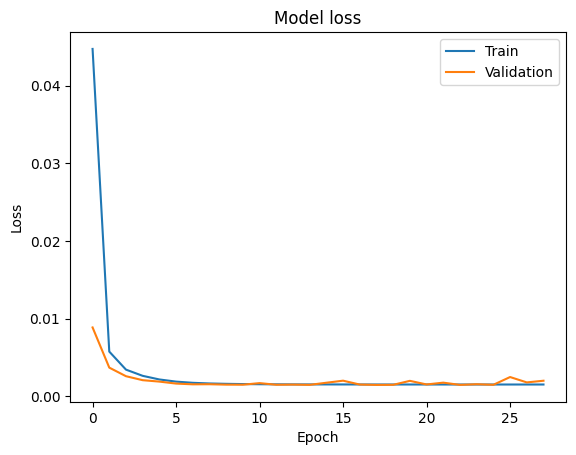

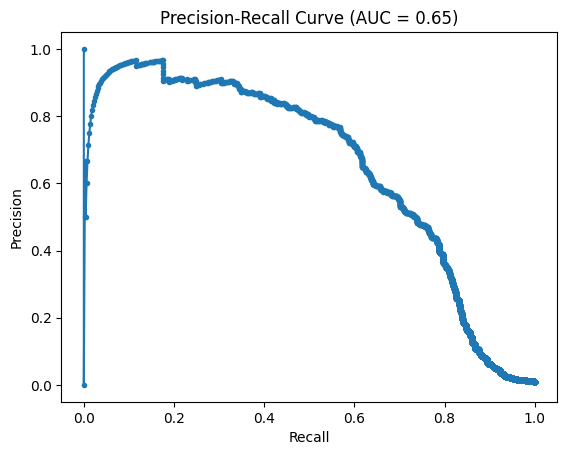

In [32]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(error_df['True_class'], error_df['Predicted_class'])
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(error_df['True_class'], error_df['Predicted_class'])
print("Classification Report:\n", class_report)

# Calculate and print F1-score, precision, recall, accuracy, and AUC-ROC
y_pred = error_df['Predicted_class']
print("F1-score (micro):", f1_score(error_df['True_class'], y_pred, average='micro'))
print("Precision:", precision_score(error_df['True_class'], y_pred, average='macro'))
print("Recall:", recall_score(error_df['True_class'], y_pred, average='macro'))
print("Accuracy Score:", accuracy_score(error_df['True_class'], y_pred))
print("AUC-ROC Score:", roc_auc_score(error_df['True_class'], mse))


# Plot Confusion Matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Actual Negative', 'Actual Positive'], rotation=0)
plt.show()

#Actual Negative: True Negative (TN) + False Positive (FP)
#Actual Positive: True Positive (TP) + False Negative (FN)
#Predicted Negative: True Negative (TN) + False Negative (FN)
#Predicted Positive: True Positive (TP) + False Positive (FP)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot Precision-Recall Curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()